# Value at Risk (VaR) by MonteCarlo method in Stock Portfolio by clustering and ML algorithm for forecasting prices

## Importing the libraries we will use

In [288]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

## Variables for the stock downloader

In [575]:
years = 12
today = date.today()
start = today.replace(year=today.year - years)

## The composite and stock list we will use

In [262]:
composite = '^IXIC' #Nasdaq composite
csv = pd.read_csv('stock.csv') #Nasdaq stocks
stockList = csv['Stock'].tolist()

## Downloading the prices from yahoo finance

In [263]:
stockPrice = yf.download(stockList, start=start, end=today, interval='1d')['Adj Close']
stockPrice['Composite'] = yf.download(composite, start=start, end=today, interval='1d')['Adj Close']

[*********************100%***********************]  102 of 102 completed
[*********************100%***********************]  1 of 1 completed


## The null data is about 66.5%
### The thing in stock prices is, null prices are very common owing to closures in the market or holidays
### We need to fill those null prices

In [264]:
f"{stockPrice.isna().values.sum() / len(stockPrice):.2%}"

'1004.40%'

## We will fill by forwardfill method if the previous price exists
### If not, it means the previous price does not exists. The price will be 0

In [265]:
stockPrice = stockPrice.fillna(method='ffill')
stockPrice = stockPrice.fillna(0)

## Here we have the top 5 companies in Nasdaq

<AxesSubplot:xlabel='Date'>

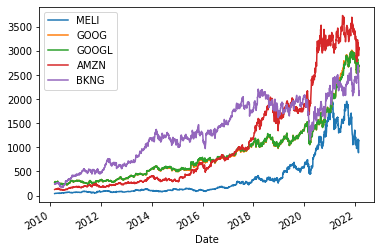

In [549]:
stockPrice[((stockPrice[stockList].mean()).sort_values(axis=0)[-5:]).index].plot()

## Beta and Return calculator

### We will create the beta and return column for each stock.
### Then, the composite row will be dropped for clustering method

In [267]:
returns = stockPrice.pct_change()
reu = returns.fillna(0)
reu = reu.replace(np.inf, 0)
reu = reu.mean()
beta = (returns.cov()['Composite'])/(returns['Composite'].var())
stockSummary = pd.concat([beta, reu], axis=1)
stockSummary = stockSummary.rename(columns={'Composite': 'Beta',0: 'Returns'})
composite_summary = stockSummary.loc['Composite']
stockSummary = stockSummary.drop(['Composite'], axis=0)
stockSummary = stockSummary.dropna(axis=0)

## Clustering by K-Means (Elbow method)
### We will plot the clusters and the centroids.

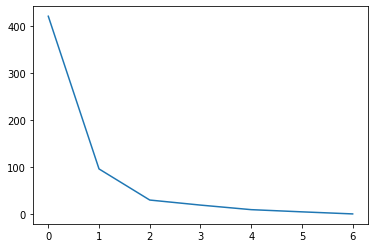

In [270]:
z = 8
wcss = []
for i in range(1, z):
    kmeans = KMeans(n_clusters=i, max_iter=300)
    kmeans.fit(stockSummary)
    wcss.append(kmeans.inertia_)  
clustering = KMeans(n_clusters=z, max_iter=300)
clustering.fit(stockSummary)
stockSummary['Clusters'] = clustering.labels_
plt.plot(wcss)
plt.show()

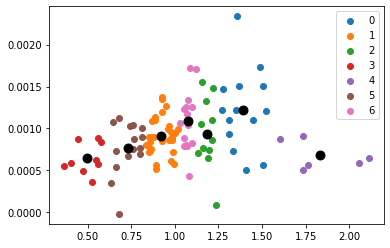

In [271]:
label = kmeans.fit_predict(stockSummary)
centroids = kmeans.cluster_centers_
uniqueLabels = np.unique(label)
 
for i in uniqueLabels:
    plt.scatter(stockSummary.iloc[label==i, 0], stockSummary.iloc[label==i ,1], label=i)
plt.scatter(centroids[:,0], centroids[:,1], s=80, color='black')
plt.legend()
plt.show()

## Summary of each cluster
### If beta > 1, means the stock has volatility. The profit will be higher.
### If beta < 1, means the stock is so secure. The profit will be lower.

### Now, we need to choose some cluster.

In [272]:
means = stockSummary.groupby('Clusters').mean()
means

,Beta,Returns
Clusters,,
0,0.922882,0.000905
1,1.073306,0.001088
2,0.730503,0.000767
3,1.390458,0.001224
4,0.495306,0.000643
5,1.709572,0.000715
6,2.082802,0.000617
7,1.186394,0.000938


In [273]:
stockSummary['Clusters'].value_counts()

0    31
1    15
2    15
3    15
7    11
4     9
5     4
6     2
Name: Clusters, dtype: int64

## The cluster selected
### We choosed the 3rd cluster, thanks to the fact that the return is the biggest in the box
### We will use a confidence interval of 30% for choose the best portfolio
### Also, we will use only the stocks which beta and return values are higher than mean - standard desviation 
### In case the portfolio list had more than five tickers, the random will choose only five

In [274]:
higherReturn = ((stockSummary.groupby('Clusters').mean())['Returns'].sort_values()[1:]).index[0]
selectedCluster = stockSummary[stockSummary['Clusters'] == higherReturn]
confidenceInterval = 0.3
portfolio = selectedCluster[selectedCluster['Returns'] > (selectedCluster.mean()['Returns'] - (selectedCluster.std()['Returns']))]
portfolioTicker = (portfolio.index).tolist()
portfolioTicker = np.random.choice(portfolioTicker, 5, replace=False)
portfolioTicker

array(['COST', 'AZN', 'KDP', 'PEP', 'AEP'], dtype='<U4')

## Here we have the portfolio's yield

<AxesSubplot:xlabel='Date'>

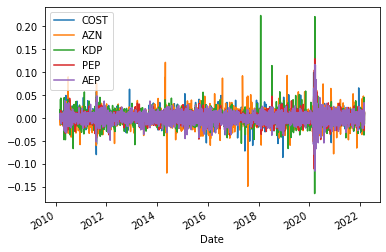

In [551]:
portfolioReturn = (stockPrice[portfolioTicker].pct_change()).dropna()
lastPrice = stockPrice[portfolioTicker].iloc[-1]
portfolioReturn.plot()

## The portfolio has a normal distribution
### In the long term, thanks to the Central Limit Theorem, all the paths they may take will fulfill the CLT 

<AxesSubplot:ylabel='Density'>

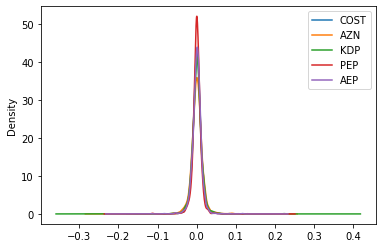

In [310]:
portfolioDensity = (stockPrice[portfolioTicker]).pct_change().plot.kde()
portfolioDensity

## MonteCarlo

In [573]:
def monte_carlo(returns, tickers, simulations=10000, capital=10000, t=100):
    weights = np.random.random(len(tickers)) #the weigth of each stock in the portfolio, the sum will be 1
    weights /= np.sum(weights)
    meanMatrix = (np.full(shape=(t, len(tickers)), fill_value=returns.mean())).T
    portfolioSimulations = np.full(shape=(t, simulations), fill_value=0)
    for i in range(0, simulations):
        zFactor = np.random.normal(size=(t, len(tickers)))
        Cholesky = np.linalg.cholesky(returns.cov())
        dailyReturns = meanMatrix + np.inner(Cholesky, zFactor)
        portfolioSimulations[:, i] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio
    return portfolioSimulations

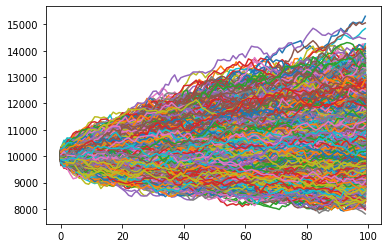

In [574]:
monteCarlo = monte_carlo(portfolioReturn, portfolioTicker)
plt.plot(monteCarlo)
plt.show()

## VaR

In [585]:
def VaR(returns, capital=10000, confidence_interval=95):
    VaR = capital - np.percentile(returns, 100-confidenceLevel)
    CVaR = capital - returns[returns <= np.percentile(returns, 100-confidenceLevel)].mean()
    print('VaR ${}'.format(round(VaR, 2)))
    print('CVaR ${}'.format(round(CVaR, 2)))
VaRReturns = portfolioSimulations[-1,:]
portfolioVaR = VaR(VaRReturns)

VaR $959.0
CVaR $1262.32


## Historical price

<AxesSubplot:xlabel='Date'>

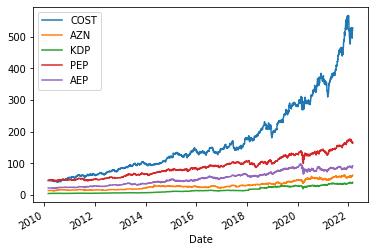

In [546]:
stockPrice[portfolioTicker].plot()

## Variance

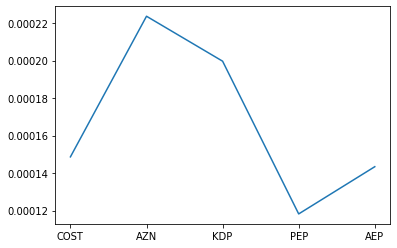

In [281]:
plt.plot(portfolioReturn.var())
plt.show()

## Forecasting

In [494]:
def forecasting(stockValues, stockTicker):
    data = stockValues.values
    dataLenght = round(len(data)*.8)#80% of the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)
    trainData = scaledData[0:dataLenght, :]
    xTrain, yTrain = [], []
    for i in range(60, len(trainData)):
        xTrain.append(trainData[i-60:i, 0])
        yTrain.append(trainData[i, 0])
    xTrain, yTrain = np.array(xTrain), np.array(yTrain)
    xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(xTrain.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(xTrain, yTrain, batch_size=1, epochs=1)
    testData = scaledData[dataLenght - 60:,:]
    xTest, yTest = [], data[dataLenght:,:]
    for i in range(60, len(testData)):
        xTest.append(testData[i-60:i, 0])
    xTest = np.array(xTest)
    xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))
    forecasting = model.predict(xTest)
    forecasting = scaler.inverse_transform(forecasting)
    rmse = np.sqrt(np.mean(forecasting-yTest)**2)
    train = data[:dataLenght]
    valid= pd.DataFrame(data[dataLenght:], columns=['Original {}'.format(stockTicker)])
    valid['Forecast {}'.format(stockTicker)] = forecasting
    return valid

In [495]:
forec = []
for i in range(0, len(portfolioTicker)):
    print(portfolioTicker[i:i+1][0])
    vars()[portfolioTicker[i:i+1][0]] = forecasting(stockPrice[portfolioTicker[i:i+1]], portfolioTicker[i:i+1][0])
    forec.append(vars()[portfolioTicker[i:i+1][0]])
forecast = pd.concat(forec, axis=1)
forecast.head()

COST
2358/2358 [==============================] - 45s 18ms/step - loss: 2.4364e-04
AZN
2358/2358 [==============================] - 48s 20ms/step - loss: 5.1543e-04
KDP
2358/2358 [==============================] - 47s 19ms/step - loss: 5.9011e-04
PEP
2358/2358 [==============================] - 52s 21ms/step - loss: 7.5310e-04
AEP
2358/2358 [==============================] - 49s 20ms/step - loss: 7.0582e-04


,Original COST,Forecast COST,Original AZN,Forecast AZN,Original KDP,Forecast KDP,Original PEP,Forecast PEP,Original AEP,Forecast AEP
0,283.665558,287.579071,40.398598,38.364025,25.850863,25.265339,129.238937,126.308617,85.414612,85.804268
1,283.894867,288.701141,40.584766,38.428669,26.365973,25.264961,129.276443,126.482971,85.166321,85.732361
2,284.334381,289.898346,40.566154,38.574867,26.528133,25.313908,129.042068,126.613632,84.918022,85.644867
3,284.257874,291.044464,40.808174,38.728561,26.137032,25.394785,128.863922,126.685890,84.632935,85.534058
4,285.089111,292.029053,41.152580,38.904305,26.261040,25.438856,127.813896,126.704689,84.366241,85.394386
...,...,...,...,...,...,...,...,...,...,...
599,505.579987,504.487732,58.130001,56.618298,36.650002,36.415642,163.789993,162.409576,86.559998,86.074532
600,517.489990,503.154816,60.580002,56.221394,38.299999,36.251583,168.380005,161.962250,89.459999,85.978859
601,519.250000,503.624725,60.880001,56.284458,38.669998,36.225948,163.740005,161.889923,90.650002,86.275848
602,522.929993,504.984863,61.340000,56.580791,38.160000,36.282135,162.270004,161.524628,90.209999,86.864700


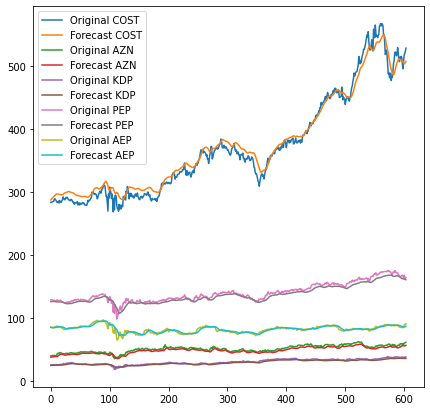

In [590]:
plt.figure(figsize=(7,7))
plt.plot(forecast)
plt.legend(forecast.columns)
plt.show()

## VaR for forecasted portfolio

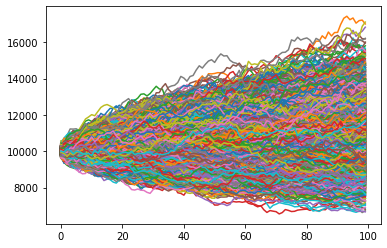

In [577]:
forecastedReturn = (forecast.loc[:, ::2]).pct_change().dropna()
forecastedMonteC = monte_carlo(forecastedReturn, portfolioTicker)
plt.plot(forecastedMonteC)
plt.show()

In [586]:
forecastedVaRRet = forecastedPortfolio[-1,:]
forecastedVaR = VaR(forecastedVaRRet)

VaR $1575.05
CVaR $2037.77
